<a href="https://colab.research.google.com/github/Kaiziferr/-Miner_Detector/blob/master/Sequential/12_series_tiempo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('./data/international-airline-passengers.csv', usecols=[1], engine='python')

In [3]:
data.tail(1)

,Passengers
143,432


Text(0, 0.5, 'pasajeros')

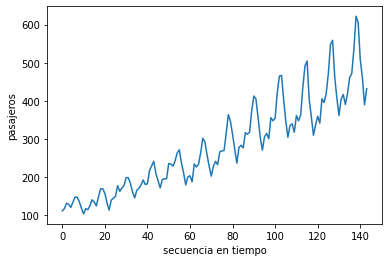

In [4]:
plt.plot(data)
plt.xlabel('secuencia en tiempo')
plt.ylabel('pasajeros')

- Hay una tendencia
- Parece haber una perioxidad (Cuando hay vacaciones podria haber un alza)

#MLP para regresión

- La escritura de una función simple para convertir la única columna de datos en un conjunto de datos de dos columnas. La primera columna contiene el recuento de pasajeros en el instante *t* de este mes y la segunda columna contiene el recuento de pasajeros en el momento *t+1* del proximo mes (por predecir)

In [5]:
import numpy as np
import math
from keras.models import Sequential
from keras.layers import Dense

In [6]:
data_values = data.values
data_values = data_values.astype('float32')

Con datos de serie de tiempo, la secuencia de valores es importante. Un metodo simple para entrenamiento es dividir el conjunto de datos ordenado en conjuntos de datos de prueba/validación. En este caso vamos a modelarlo en 67% para prueba y 33% para validación


In [7]:
train_size = int(len(data_values)*0.67)
test_set = len(data_values) - train_size
train, test = data_values[0:train_size, :], data_values[train_size:, :]
display(len(data_values), len(train), len(test) )

144

96

48

Ahora podemos definir una función para crear un nuevo conjunto de datos como se describio anteriormente.

- El **conjunto de datos**
- La "**vista hacia atrás**" que es el número de pasos de tiempo anteriores predeterminado a 1
  - Este valor predeterminado creará un conjunto de datos donde X es el número de pasajeros en un momento dado (*t*) e **Y** es el número de pasajeros en el siguiente momento (t+1)

In [21]:
def create_dataset(data, loock_back = 1):
  dataX, dataY = [], []
  for i in range(len(data) - loock_back-1):
    a = data[i: (i+loock_back), 0]
    dataX.append(a)
    dataY.append(data[i+loock_back, 0])
  return np.array(dataX), np.array(dataY)

In [22]:
loock_back = 1
trainX, trainY = create_dataset(train, loock_back)
testX, testY = create_dataset(test, loock_back)
for i in range(5):
  print(trainX[i], trainY[i])

[112.] 118.0
[118.] 132.0
[132.] 129.0
[129.] 121.0
[121.] 135.0


In [29]:
model = Sequential()
model.add(Dense(8, input_dim = loock_back, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer = 'adam')
model.fit(trainX, trainY, epochs=200, batch_size = 2, verbose = 0)

In [30]:
#Estimar performance
train_score = model.evaluate(trainX, trainY, verbose=0)
print('PPuntuacion Entrenamiento: %2f MSE (%.2f RMSE)' % (train_score, math.sqrt(train_score)))
test_score = model.evaluate(testX, testY, verbose=0)
print('PPuntuacion Validation: %2f MSE (%.2f RMSE)' % (test_score, math.sqrt(test_score)))

PPuntuacion Entrenamiento: 532.284119 MSE (23.07 RMSE)
PPuntuacion Validation: 2356.138672 MSE (48.54 RMSE)


# Prediccion modelo

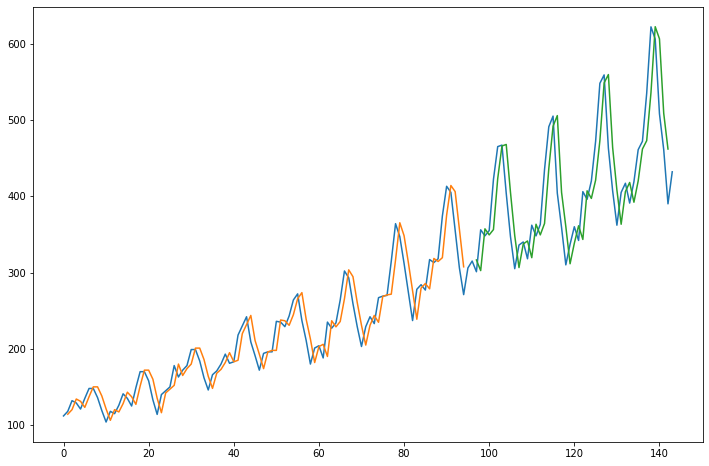

In [13]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredictPlot = np.empty_like(data_values)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[loock_back: len(trainPredict)+loock_back, :] = trainPredict

testPredictPlot = np.empty_like(data_values)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(trainPredict)+(loock_back*2)+1:len(data_values)-1,:] = testPredict

plt.figure(figsize=(12,8))
plt.plot(data_values)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

Hacer la predicción para el próximo paso de tiempo se denomina método de ventana y el tamaño de la ventana es un parametro que se puede ajustar.

Por ejemplo, dado el tiempo actual (t) se requiere predecir el valor en el proximo tiempo en la secuencia t+1, entonces se puede usar el tiempo actual t, asi como los dos tiempos anteriores (t-1) y (t-2)

In [ ]:
loock_back = 3
trainX, trainY = create_dataset(train, loock_back)
testX, testY = create_dataset(test, loock_back)

model = Sequential()
model.add(Dense(12, input_dim = loock_back, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=400, batch_size=2, verbose=2)

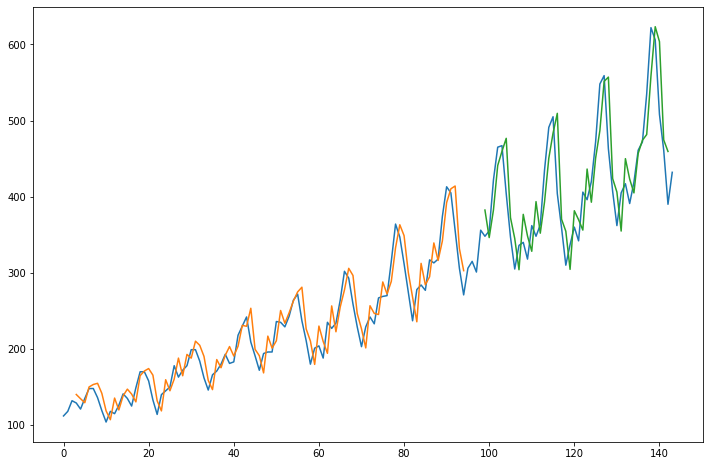

In [49]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredictPlot = np.empty_like(data_values)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[loock_back: len(trainPredict)+loock_back, :] = trainPredict

testPredictPlot = np.empty_like(data_values)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(trainPredict)+(loock_back*2)+1:len(data_values)-1,:] = testPredict

plt.figure(figsize=(12,8))
plt.plot(data_values)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

In [50]:
#Estimar performance
train_score = model.evaluate(trainX, trainY, verbose=0)
print('PPuntuacion Entrenamiento: %2f MSE (%.2f RMSE)' % (train_score, math.sqrt(train_score)))
test_score = model.evaluate(testX, testY, verbose=0)
print('PPuntuacion Validation: %2f MSE (%.2f RMSE)' % (test_score, math.sqrt(test_score)))

PPuntuacion Entrenamiento: 455.348206 MSE (21.34 RMSE)
PPuntuacion Validation: 1894.082397 MSE (43.52 RMSE)


# El modelo no se ajustado muy bien, toca investigar